# Pareto Frontiers for unigling Frame Objective: Robustness & Fidelity Trade-off


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [3]:
# Problem parameters
T = 25
Δt = 0.2
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 2

In [3]:
propertynames(sys)

(:H, :G, :n_drives, :levels, :params)

In [4]:
typeof(sys.H)

PiccoloQuantumObjects.QuantumSystems.var"#6#15"{SparseMatrixCSC{ComplexF64, Int64}, Vector{SparseMatrixCSC{ComplexF64, Int64}}}

In [5]:
length(sys.H.H_drives)
X_drive = sys.H.H_drives[1]
X_drive === H_drive[1]

false

### Pareto Frontiers

In [7]:
n_guesses = 3
n_drives = sys.n_drives

def_seeds = []
add_seeds = []
mult_seeds = []
both_seeds = []
n_seeds = n_guesses


for i in 1:n_seeds
    Random.seed!(1234+i)
    a_bounds = fill(1.0, n_drives)
    da_bounds = fill((8+i)*π*Δt/T, n_drives)
    dda_bounds = fill(1.0, n_drives)
    control_bounds = (a_bounds, da_bounds, dda_bounds)
    def_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )
    push!(def_seeds, def_traj)

    add_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )
    push!(add_seeds, add_traj)

    mult_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                system=sys
            )
    push!(mult_seeds, mult_traj)

    both_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                system=sys
            )
    push!(both_seeds, both_traj)
end



In [5]:
# typeof(UnitarySmoothPulseProblem)
a_vals = exp.(range(log(100), log(100000), length=10))
final_fid_floor_log = 1 .- 1 ./ a_vals


10-element Vector{Float64}:
 0.99
 0.9953584111663872
 0.9978455653099682
 0.999
 0.9995358411166387
 0.9997845565309968
 0.9999
 0.9999535841116639
 0.9999784556530997
 0.99999

In [8]:
a_vals = exp.(range(log(100), log(100000), length=10))
final_fid_floor_log = 1 .- 1 ./ a_vals
final_fid_floor = final_fid_floor_log

# final_fid_floor = [1-a for a in 0.01:-0.001:0.00001]
# final_fid_floor = [0.99, 0.993, 0.996, 0.999, 0.9993, 0.9996, 0.9999, 0.99993, 0.99996, 0.99999]
n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_both_probs = Matrix{Any}(undef, n_seeds, n_nines)

init_def_fids = zeros(n_seeds, n_nines)
init_add_fids = zeros(n_seeds, n_nines)
init_mult_fids = zeros(n_seeds, n_nines)
Hₑ_add = a -> PAULIS.X
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive

for i in 1:n_seeds
    for j in 1:n_nines
        
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(def_seeds[i]))
        default_probs[i, j] = default
        def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
        init_def_fids[i,j] = def_fid

        add_uni_prob = UnitaryUniversalProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(add_seeds[i]), activate_hyperspeed=true, Q_t=0.1)
        init_add_probs[i, j] = add_uni_prob
        add_fid = unitary_rollout_fidelity(init_add_probs[i, j].trajectory, sys)
        init_add_fids[i,j] = add_fid

        mult_uni_prob = UnitaryUniversalProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(mult_seeds[i]), activate_hyperspeed=true, Q_t=0.1)
        init_mult_probs[i, j] = mult_uni_prob
        mult_fid = unitary_rollout_fidelity(init_mult_probs[i, j].trajectory, sys)
        init_mult_fids[i,j] = mult_fid
    end
end


for i in 1:n_seeds
    for j in 1:n_nines
        takes = 1
        while takes < 25 && init_add_fids[i,j] < 0.9900000
            solve!(init_add_probs[i, j]; max_iter=8, print_level=1)
            init_add_fid = unitary_rollout_fidelity(init_add_probs[i, j].trajectory, sys)
            init_add_fids[i,j] = init_add_fid
            takes += 1
        end
        
        takes = 1
        while takes < 25 && init_mult_fids[i,j] < 0.9900000
            solve!(init_mult_probs[i, j]; max_iter=8, print_level=1)
            init_mult_fid = unitary_rollout_fidelity(init_mult_probs[i, j].trajectory, sys)
            init_mult_fids[i,j] = init_mult_fid
            takes += 1
        end
    end
end



    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integra

In [9]:

# warm_mult = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(init_mult_probs[i, j].trajectory))
warm_add_probs = [UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(init_add_probs[i, j].trajectory)) for i in 1:n_seeds, j in 1:n_nines]
warm_mult_probs = [UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(init_mult_probs[i, j].trajectory)) for i in 1:n_seeds, j in 1:n_nines]


for i in 1:n_seeds
    for j in 1:n_nines
        takes = 1
        while takes < 150 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=6, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end

        takes = 1
        while takes < 50 && init_add_fids[i,j] < final_fid_floor[j]
            solve!(warm_add_probs[i, j]; max_iter=10, print_level=1)
            warm_add_fid = unitary_rollout_fidelity(warm_add_probs[i, j].trajectory, sys)
            init_add_fids[i,j] = warm_add_fid
            takes += 1
        end

        takes = 1
        while takes < 50 && init_mult_fids[i,j] < final_fid_floor[j]
            solve!(warm_mult_probs[i, j]; max_iter=10, print_level=1)
            warm_mult_fid = unitary_rollout_fidelity(warm_mult_probs[i, j].trajectory, sys)
            init_mult_fids[i,j] = warm_mult_fid
            takes += 1
        end
    end
end

    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	u

Ensure default fidelity is up to snuff

In [10]:
# Default
for i in 1:n_seeds
    for j in 1:n_nines
        takes = 1
        while takes < 150 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=10, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end
    end
end

Initial Fidelity Summary Table

In [11]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Add Fidelity | Mult Fidelity ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            add_fid = unitary_rollout_fidelity(warm_add_probs[seed_idx, j].trajectory, sys)
            mult_fid = unitary_rollout_fidelity(warm_mult_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |      0.99996 |     0.999957 |      0.999481 |"

"0.995358 |      0.99996 |     0.999957 |      0.999481 |"

"0.997846 |      0.99996 |     0.999957 |      0.999481 |"

"  0.999 |      0.99996 |     0.999957 |      0.999481 |"

"0.999536 |      0.99996 |     0.999957 |      0.999997 |"

"0.999785 |      0.99996 |     0.999957 |      0.999997 |"

" 0.9999 |      0.99996 |     0.999957 |      0.999997 |"

"0.999954 |      0.99996 |     0.999957 |      0.999997 |"

"0.999978 |     0.999998 |          1.0 |      0.999997 |"

"0.99999 |     0.999998 |          1.0 |      0.999997 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.998793 |     0.999836 |       0.99992 |"

"0.995358 |     0.998793 |     0.999836 |       0.99992 |"

"0.997846 |     0.998793 |     0.999836 |       0.99992 |"

"  0.999 |     0.999318 |     0.999836 |       0.99992 |"

"0.999536 |     0.999998 |     0.999836 |       0.99992 |"

"0.999785 |     0.999998 |     0.999836 |       0.99992 |"

" 0.9999 |     0.999998 |     0.999998 |       0.99992 |"

"0.999954 |     0.999998 |     0.999998 |      0.999999 |"

"0.999978 |     0.999998 |     0.999998 |      0.999999 |"

"0.99999 |     0.999998 |     0.999998 |      0.999999 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.995024 |     0.999117 |      0.999983 |"

"0.995358 |     0.999829 |     0.999117 |      0.999983 |"

"0.997846 |     0.999829 |     0.999117 |      0.999983 |"

"  0.999 |     0.999829 |     0.999117 |      0.999983 |"

"0.999536 |     0.999829 |     0.999868 |      0.999983 |"

"0.999785 |     0.999829 |     0.999868 |      0.999983 |"

" 0.9999 |     0.999973 |     0.999998 |      0.999983 |"

"0.999954 |     0.999973 |     0.999998 |      0.999983 |"

"0.999978 |     0.999998 |     0.999998 |      0.999983 |"

"0.99999 |     0.999998 |     0.999998 |           1.0 |"

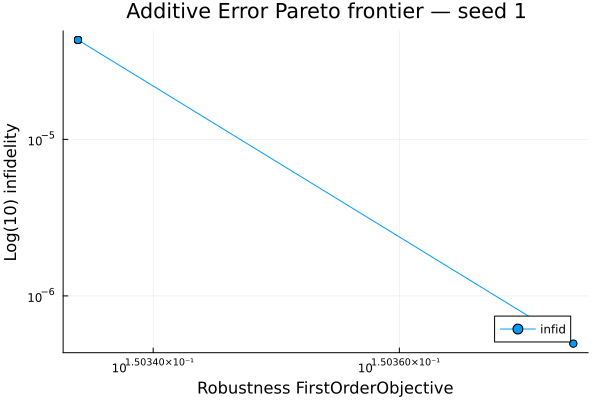

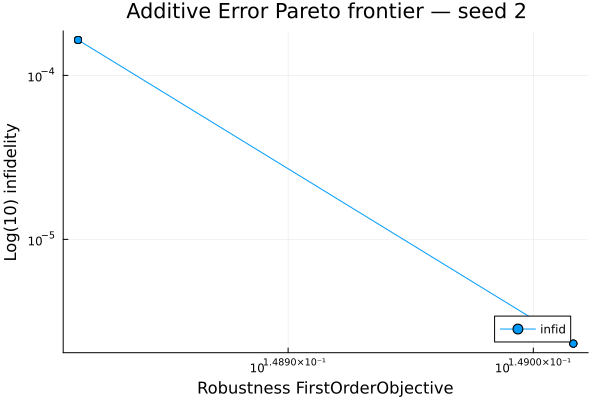

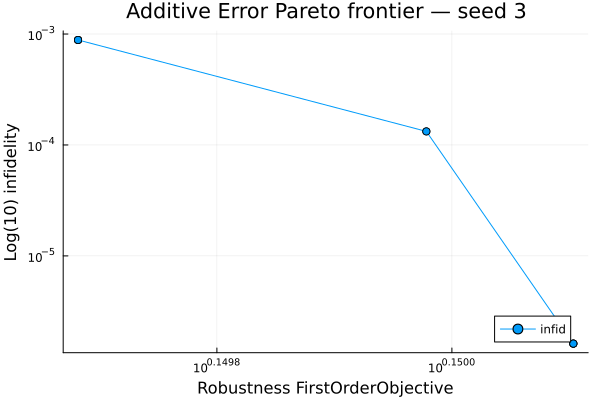

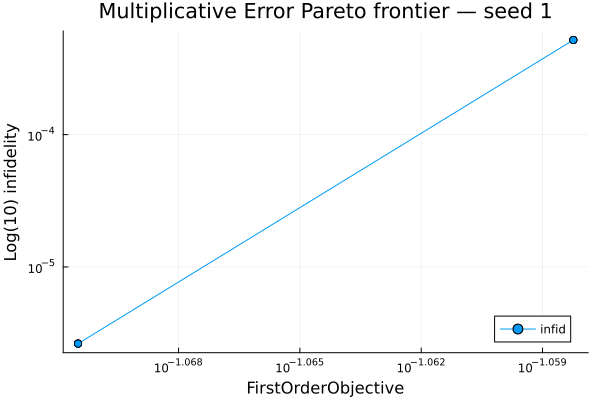

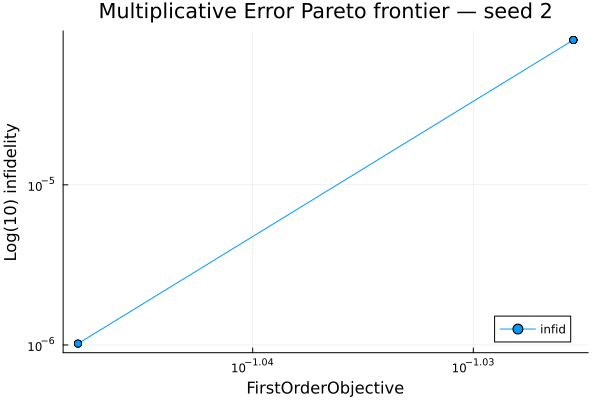

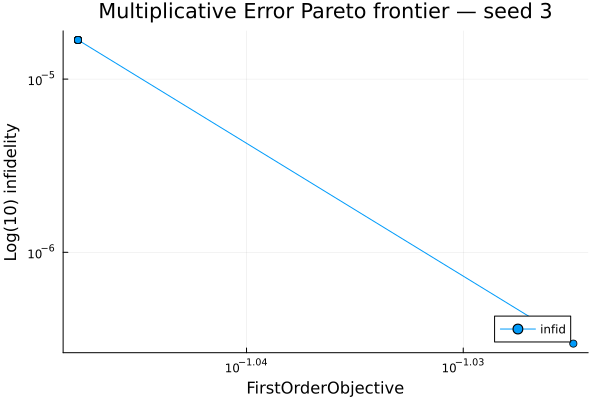

In [12]:
for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness FirstOrderObjective",
        ylabel="Log(10) infidelity",
        title="Additive Error Pareto frontier — seed $s",
        xscale = :log10, yscale = :log10,
        legend=:bottomright, grid=true
    )
    xs = Float64[]
    ys = Float64[]
    for (j, f) in enumerate(final_fid_floor)
        add_prob = warm_add_probs[s, j]
        Hₑ_add = a -> PAULIS.X
        obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
        Z_vec = vec(add_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, 1-unitary_rollout_fidelity(add_prob.trajectory, sys))
    end
    # sort by x for a nice line
    ord = sortperm(xs)
    name = "infid"
    Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=name)
    display(plt)
end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="FirstOrderObjective",
        ylabel="Log(10) infidelity",
        title="Multiplicative Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true,
        xscale = :log10, yscale = :log10
    )
    xs = Float64[]  # robustness
    ys = Float64[]  # fidelity
    for (j, f) in enumerate(final_fid_floor)
        mult_prob = warm_mult_probs[s, j]
        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive
        obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
        Z_vec = vec(mult_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, 1-unitary_rollout_fidelity(mult_prob.trajectory, sys))
    end
    # sort by x for a nice line
    ord = sortperm(xs)
    name = "infid"
    Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=String(name))
    display(plt)
end

Solve Max-Universal Problems

In [13]:
n_nines = length(final_fid_floor)
final_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
# final_both_probs = Matrix{Any}(undef, n_seeds, n_nines)

for i in 1:n_seeds
    for j in 1:n_nines
        Hₑ_add = a -> PAULIS.X
        add_prob = UnitaryMaxUniversalProblem(
                warm_add_probs[i,j],
                U_goal;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(add_prob, max_iter=250, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(add_prob, max_iter=50, print_level=5)
        final_add_probs[i,j] = add_prob

        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive

        mult_prob = UnitaryMaxUniversalProblem(
                warm_mult_probs[i,j],
                U_goal;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(mult_probv, max_iter=250, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(mult_prob, max_iter=50, print_level=5)
        final_mult_probs[i,j] = mult_prob

        
        # Hₑ_both = a -> PAULIS.X + a[1] * X_drive
        # both_prob = UnitaryUniversalProblem(
        #     sys, U_goal, T, Δt, Hₑ_both;
        #     piccolo_options=piccolo_opts
        #     )
        # solve!(both_prob, max_iter=150, print_level=5)

    end
end



UndefVarError: UndefVarError: `traj` not defined in `QuantumCollocation.ProblemTemplates`
Suggestion: check for spelling errors or missing imports.

In [14]:
# for i in 1:n_seeds
#     for j in 1:n_nines
#         add_prob = final_add_probs[i,j]
#         solve!(add_prob, max_iter=250, print_level=5)

#         mult_prob = final_mult_probs[i,j]
#         solve!(mult_prob, max_iter=250, print_level=5)
#     end
# end

Pareto Frontiers

sorted by fidelity min

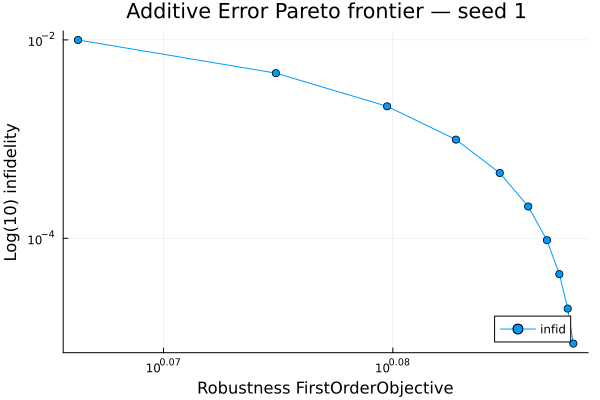

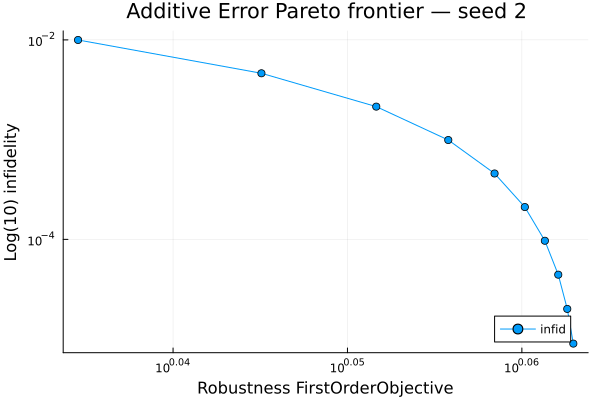

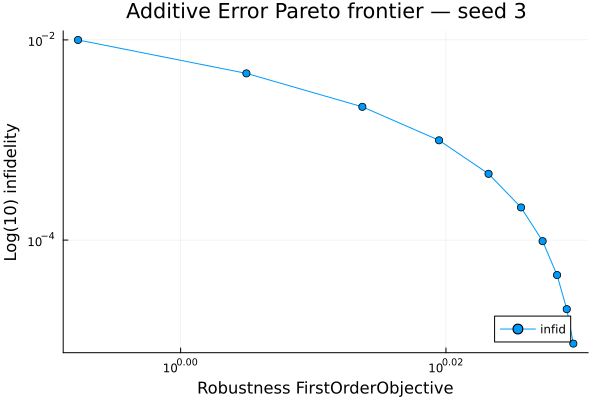

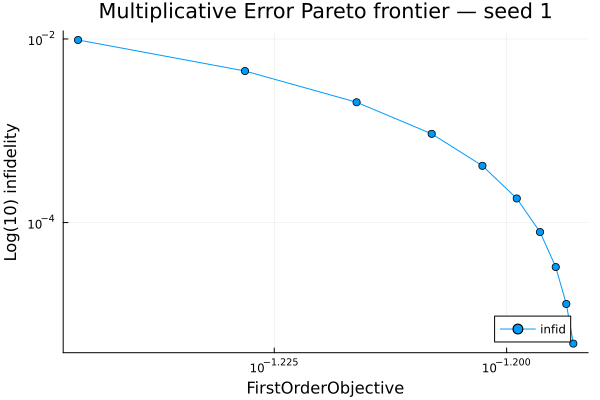

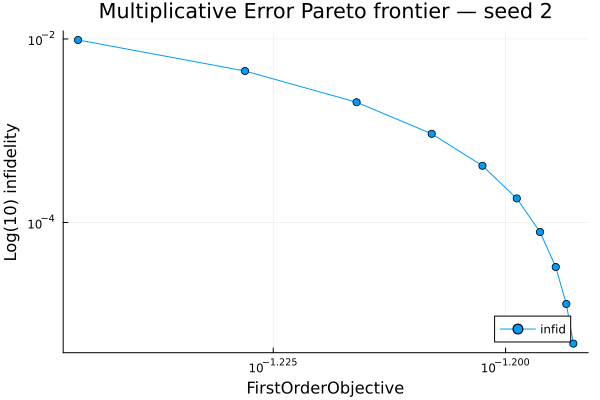

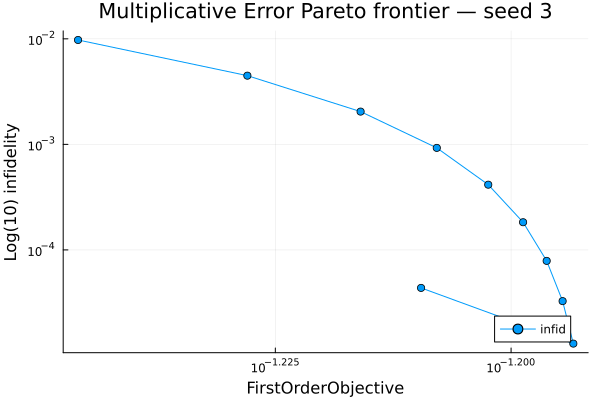

In [16]:
for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness FirstOrderObjective",
        ylabel="Log(10) infidelity",
        title="Additive Error Pareto frontier — seed $s",
        xscale = :log10, yscale = :log10,
        legend=:bottomright, grid=true
    )
    xs = Float64[]
    ys = Float64[]
    for (j, f) in enumerate(final_fid_floor)
        add_prob = final_add_probs[s, j]
        Hₑ_add = a -> PAULIS.X
        obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
        Z_vec = vec(add_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, 1-unitary_rollout_fidelity(add_prob.trajectory, sys))
    end
    # sort by x for a nice line
    # ord = sortperm(xs)
    name = "infid"
    Plots.plot!(plt, xs, ys, marker=:circle, label=name)
    display(plt)
end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="FirstOrderObjective",
        ylabel="Log(10) infidelity",
        title="Multiplicative Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true,
        xscale = :log10, yscale = :log10
    )
    xs = Float64[]  # robustness
    ys = Float64[]  # fidelity
    for (j, f) in enumerate(final_fid_floor)
        mult_prob = final_mult_probs[s, j]
        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive
        obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
        Z_vec = vec(mult_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, 1-unitary_rollout_fidelity(mult_prob.trajectory, sys))
    end
    # sort by x for a nice line
    # ord = sortperm(xs)
    name = "infid"
    Plots.plot!(plt, xs, ys, marker=:circle, label=String(name))
    display(plt)
end

fid min

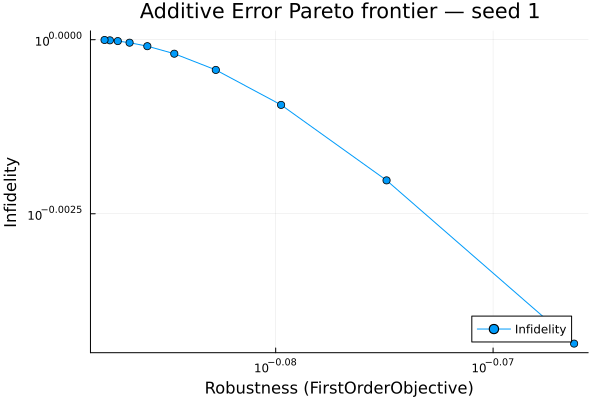

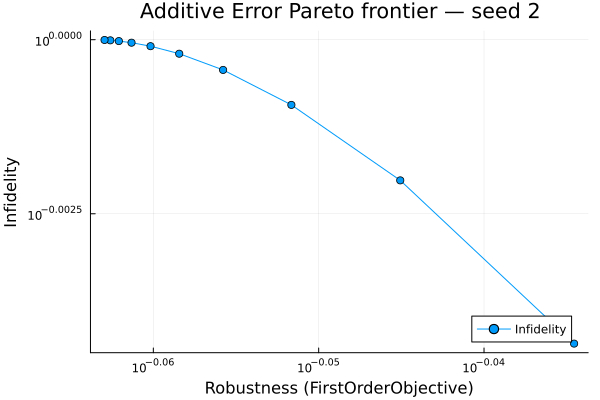

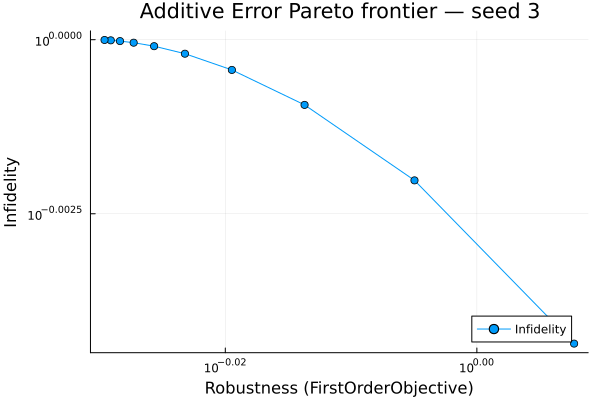

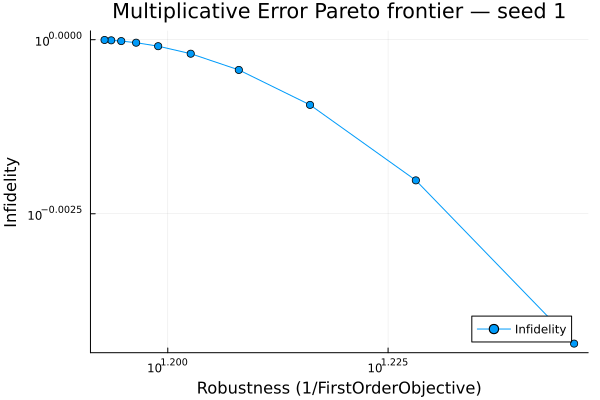

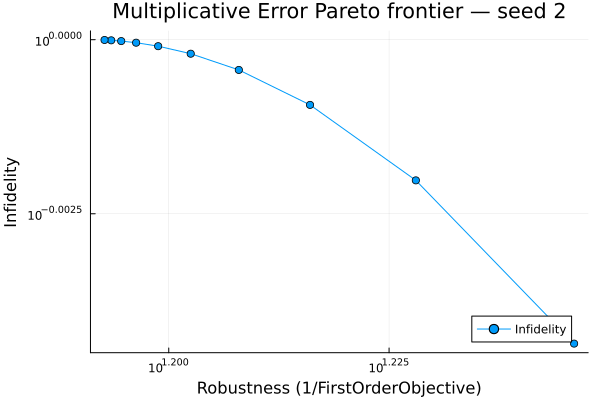

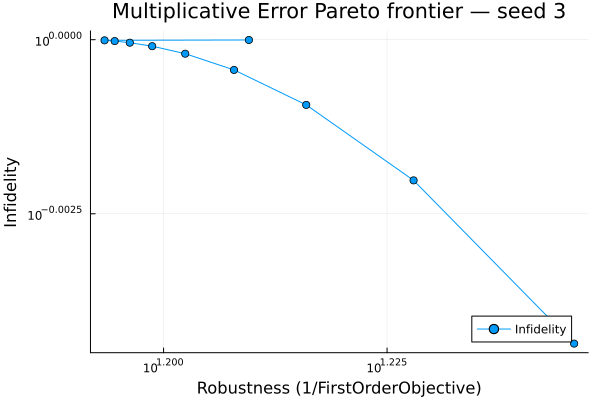

In [17]:
for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (FirstOrderObjective)",
        ylabel="Infidelity",
        title="Additive Error Pareto frontier — seed $s",
        xscale = :log10, yscale = :log10,
        legend=:bottomright, grid=true
    )
    xs = Float64[]
    ys = Float64[]
    for (j, f) in enumerate(final_fid_floor)
        add_prob = final_add_probs[s, j]
        Hₑ_add = a -> PAULIS.X
        obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
        Z_vec = vec(add_prob.trajectory)
        obj_val = 1/obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, f)
        # push!(ys, y_fid)
    end
    name = "Infidelity"
    Plots.plot!(plt, xs, ys, marker=:circle, label="Infidelity")
    display(plt)
end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (1/FirstOrderObjective)",
        ylabel="Infidelity",
        title="Multiplicative Error Pareto frontier — seed $s",
        xscale = :log10, yscale = :log10,
        legend=:bottomright, grid=true
    )
    xs = Float64[]  # robustness
    ys = Float64[]  # fidelity
    for (j, f) in enumerate(final_fid_floor)
        mult_prob = final_mult_probs[s, j]
        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive
        obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
        Z_vec = vec(mult_prob.trajectory)
        obj_val = 1/obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, f)
    end
    name = "Infidelity"
    Plots.plot!(plt, xs, ys, marker=:circle, label="Infidelity")
    display(plt)
end

### sanity checks 

Final Fidelity Table

In [18]:
H_drive_add = H_drive
εs = 0:0.005:0.2
# colors = Makie.wong_colors()

# Get fid for each problem
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Final f | Base Fidelity | Add Fidelity | Mult Fidelity ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            add_fid = unitary_rollout_fidelity(final_add_probs[seed_idx, j].trajectory, sys)
            mult_fid = unitary_rollout_fidelity(final_mult_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Final f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |      0.99996 |     0.990023 |      0.990248 |"

"0.995358 |      0.99996 |      0.99538 |      0.995523 |"

"0.997846 |      0.99996 |     0.997862 |      0.997956 |"

"  0.999 |      0.99996 |     0.999012 |      0.999074 |"

"0.999536 |      0.99996 |     0.999544 |      0.999585 |"

"0.999785 |      0.99996 |     0.999791 |      0.999817 |"

" 0.9999 |      0.99996 |     0.999904 |      0.999921 |"

"0.999954 |      0.99996 |     0.999956 |      0.999967 |"

"0.999978 |     0.999998 |      0.99998 |      0.999987 |"

"0.99999 |     0.999998 |     0.999991 |      0.999995 |"

"\nseed idx = 2:"

"Final f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.998793 |     0.990024 |      0.990249 |"

"0.995358 |     0.998793 |     0.995376 |      0.995524 |"

"0.997846 |     0.998793 |     0.997858 |      0.997956 |"

"  0.999 |     0.999318 |     0.999009 |      0.999074 |"

"0.999536 |     0.999998 |     0.999542 |      0.999585 |"

"0.999785 |     0.999998 |     0.999789 |      0.999817 |"

" 0.9999 |     0.999998 |     0.999903 |      0.999921 |"

"0.999954 |     0.999998 |     0.999956 |      0.999967 |"

"0.999978 |     0.999998 |      0.99998 |      0.999987 |"

"0.99999 |     0.999998 |     0.999991 |      0.999995 |"

"\nseed idx = 3:"

"Final f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.995024 |     0.990022 |      0.990249 |"

"0.995358 |     0.999829 |     0.995373 |      0.995524 |"

"0.997846 |     0.999829 |     0.997856 |      0.997956 |"

"  0.999 |     0.999829 |     0.999007 |      0.999074 |"

"0.999536 |     0.999829 |     0.999541 |      0.999585 |"

"0.999785 |     0.999829 |     0.999788 |      0.999817 |"

" 0.9999 |     0.999973 |     0.999902 |      0.999921 |"

"0.999954 |     0.999973 |     0.999955 |      0.999967 |"

"0.999978 |     0.999998 |      0.99998 |      0.999987 |"

"0.99999 |     0.999998 |     0.999991 |      0.999956 |"

Plot Fidelity vs Error

In [19]:
εs     = 0:0.01:0.5
floors = final_fid_floor

# Build a continuous colormap and a normalizer for the floor values
cmap   = cgrad(:viridis)  # perceptually uniform
fmin, fmax = extrema(floors)
nfloor(x) = fmax == fmin ? 0.5 : (x - fmin) / (fmax - fmin)  # safeguard for flat ranges

# Helper: get the color for a given floor
floor_color(f) = cmap[nfloor(f)]

# Helper to plot one seed, additive-only
function plot_seed_additive(seed_idx; εs=εs, floors=floors)
    fig = Figure(resolution=(950,600))
    ax = Axis(fig[1,1];
        title = "Seed $(seed_idx) — additive error",
        xlabel = "ε",
        ylabel = "Fidelity"
    )

    for j in 1:length(floors)
        f = floors[j]
        c = floor_color(f)

        # Base (default) trajectory at this floor
        def_traj  = default_probs[seed_idx, j].trajectory
        # Optimized (universal) trajectory at this floor
        add_traj  = final_add_probs[seed_idx, j].trajectory

        ys_def = [unitary_rollout_fidelity(
                      def_traj,
                      QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
                  ) for ε in εs]
        ys_add = [unitary_rollout_fidelity(
                      add_traj,
                      QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
                  ) for ε in εs]

        # same hue for the pair; dashed = base, solid = optimized
        lines!(ax, εs, ys_def, color=c, linestyle=:dash,
               label="base @ $(round(f; digits=6))")
        lines!(ax, εs, ys_add, color=c, linestyle=:solid,
               label="add universal @ $(round(f; digits=6))")
    end

    # Legend + continuous colorbar keyed to floor
    axislegend(ax, position=:lb, nbanks=2)
    Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

    fig
end

# Helper to plot one seed, multiplicative-only
function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
    fig = Figure(resolution=(950,600))
    ax = Axis(fig[1,1];
        title = "Seed $(seed_idx) — multiplicative error",
        xlabel = "ε",
        ylabel = "Fidelity"
    )

    for j in 1:length(floors)
        f = floors[j]
        c = floor_color(f)

        # Base (default) trajectory at this floor
        def_traj  = default_probs[seed_idx, j].trajectory
        # Optimized (universal) trajectory at this floor
        mult_traj = final_mult_probs[seed_idx, j].trajectory

        ys_def = [unitary_rollout_fidelity(
                      def_traj,
                      QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
                  ) for ε in εs]
        ys_mult = [unitary_rollout_fidelity(
                       mult_traj,
                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
                   ) for ε in εs]

        lines!(ax, εs, ys_def,  color=c, linestyle=:dash,
               label="base @ $(round(f; digits=6))")
        lines!(ax, εs, ys_mult, color=c, linestyle=:solid,
               label="mult universal @ $(round(f; digits=6))")
    end

    axislegend(ax, position=:lb, nbanks=2)
    Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

    fig
end


plot_seed_multiplicative (generic function with 1 method)

In [20]:
εs     = 0:0.01:0.5
using Makie: LineElement


const LINE_ALPHA = 0.8
const LINEWIDTH  = 1.2
const YMAX       = 1.0

function finalize_axes!(fig, ax; cmap, fmin, fmax, ymin_seen)
    ylo = 0.9#min(0.9, ymin_seen)                   # expand lower only if needed
    Makie.ylims!(ax, ylo, 1.0)                  # qualify to avoid Plots clash

    ax.yticks = 0.90:0.02:1.00
    ax.ytickformat = vals -> string.(round.(vals; digits=2))

    # Optional grid styling (works if your Makie version exposes these fields):
    # ax.xgridvisible = true;  ax.ygridvisible = true
    # ax.xgridcolor   = (:gray, 0.25); ax.ygridcolor = (:gray, 0.25)
    # ax.xgridwidth   = 0.8;           ax.ygridwidth = 0.8

    style_elems = [
        LineElement(color=:black, linestyle=:dash,  linewidth=1.2),
        LineElement(color=:black, linestyle=:solid, linewidth=1.2),
    ]
    Makie.axislegend(ax, style_elems, ["base", "optimized"], position=:lb)
    Makie.Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")
end

function plot_seed_additive(seed_idx; εs=εs, floors=floors)
    fig = Figure(resolution=(950,600))
    ax = Axis(fig[1,1];
        title = "Seed $(seed_idx) — additive error",
        xlabel = "ε",
        ylabel = "Fidelity"
    )

    ymin_seen = Inf

    for j in 1:length(floors)
        f = floors[j]
        c = floor_color(f)

        def_traj = default_probs[seed_idx, j].trajectory
        add_traj = final_add_probs[seed_idx, j].trajectory

        ys_def = [unitary_rollout_fidelity(
                      def_traj,
                      QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
                  ) for ε in εs]
        ys_add = [unitary_rollout_fidelity(
                      add_traj,
                      QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
                  ) for ε in εs]

        # Track global minimum so we never hide data
        ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_add))

        # Same hue for the pair; dashed = base, solid = optimized
        lines!(ax, εs, ys_def, color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
        lines!(ax, εs, ys_add, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
    end

    finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
    fig
end

function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
    fig = Figure(resolution=(950,600))
    ax = Axis(fig[1,1];
        title = "Seed $(seed_idx) — multiplicative error",
        xlabel = "ε",
        ylabel = "Fidelity"
    )

    ymin_seen = Inf

    for j in 1:length(floors)
        f = floors[j]
        c = floor_color(f)

        def_traj  = default_probs[seed_idx, j].trajectory
        mult_traj = final_mult_probs[seed_idx, j].trajectory

        ys_def = [unitary_rollout_fidelity(
                      def_traj,
                      QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
                  ) for ε in εs]
        ys_mult = [unitary_rollout_fidelity(
                       mult_traj,
                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
                   ) for ε in εs]

        ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_mult))

        lines!(ax, εs, ys_def,  color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
        lines!(ax, εs, ys_mult, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
    end

    finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
    fig
end


plot_seed_multiplicative (generic function with 1 method)

In [21]:
using JLD2
using Dates

# Collect trajectories only (lighter than storing whole problem objects)
default_trajs    = [default_probs[i, j].trajectory    for i in 1:n_seeds, j in 1:n_nines]
warm_add_trajs   = [warm_add_probs[i, j].trajectory   for i in 1:n_seeds, j in 1:n_nines]
warm_mult_trajs  = [warm_mult_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
final_add_trajs  = [final_add_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
final_mult_trajs = [final_mult_probs[i, j].trajectory for i in 1:n_seeds, j in 1:n_nines]

# Optional: fidelity traces you computed
fid_traces = Dict(
    "init_def_fids"  => init_def_fids,
    "init_add_fids"  => init_add_fids,
    "init_mult_fids" => init_mult_fids,
)

# Minimal metadata to reconstruct the setup
meta = Dict(
    "T" => T,
    "Δt" => Δt,
    "U_goal" => U_goal,
    "n_seeds" => n_seeds,
    "n_nines" => n_nines,
    "final_fid_floor" => final_fid_floor,
    "control_bounds" => control_bounds,
    "n_drives" => n_drives,
)

# Make an artifacts/ folder and generate a timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "uni_pareto_trajectories_$(timestamp).jld2")

@info "Saving trajectories to $outfile"
@save outfile default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
@info "Done. Saved keys: default_trajs, warm_add_trajs, warm_mult_trajs, final_add_trajs, final_mult_trajs, fid_traces, meta"


UndefVarError: UndefVarError: `control_bounds` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

To load the data for later, use:

In [22]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
